# Problem statement

https://www.sciencedirect.com/science/article/pii/S0045782521000773

\begin{equation}
    \begin{aligned}
        \sigma_{ij,j}+b_i&=0\\
        \sigma_{ij}&=\lambda\delta_{ij}\varepsilon_{kk}+2\mu\varepsilon_{ij}\\
        \varepsilon_{ij}&=\frac{1}{2}\left(u_{i,j}+u_{j,i}\right)\\
        b_1&=\lambda\left(4\pi^2cos(2\pi x)sin(\pi y)-\pi cos(\pi x)\mathcal{Q}y^3\right)\\
        &+\mu\left(9\pi^2cos(2\pi x)sin(\pi y)-\pi cos(\pi x)\mathcal{Q}y^3\right)\\
        b_2&=\lambda\left(-3sin(\pi x)\mathcal{Q}y^2+2\pi^2sin(2\pi x)cos(\pi y)\right)\\
        &+\mu\left(-6sin(\pi x)\mathcal{Q}y^2+2\pi^2sin(2\pi x)cos(\pi y)\right)\\
        &+\mu\pi^2sin(\pi x)\mathcal{Q}y^4/4
    \end{aligned}
\end{equation}
where $\lambda=1$, $\mu=0.5$ and $\mathcal{Q}=4$

Pictorial representation of the problem set up and boundary conditions


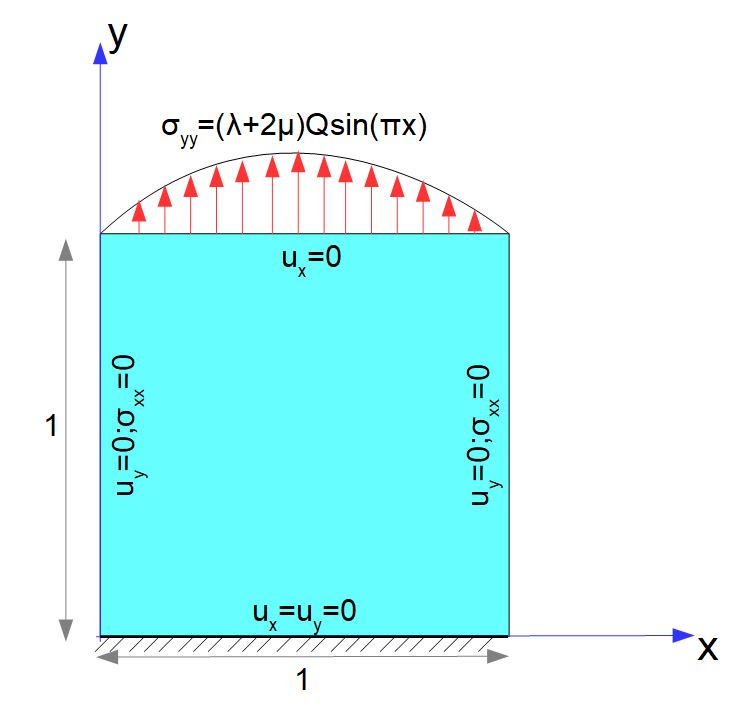

In [1]:
print("Pictorial representation of the problem set up and boundary conditions")
from IPython.display import Image
Image(filename='elastic.JPG', width = 250)

# imports

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import pickle
import FINDER_core

Using cuda device for FINDER


In [3]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


# Collocation points and boundary points

In [4]:
"""generating collocation points inside the domain"""
x = torch.linspace(0,1, steps = 40)
# x = x[1:-1]
y = torch.linspace(0,1, steps = 40)
# y = y[1:-1]
x,y = torch.meshgrid(x,y)
x = x.flatten()
y = y.flatten()
X_f_train = torch.vstack([x,y]).T.to(device)
del x,y


/home/uttam/miniforge3/envs/torch/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
X_f_train.shape

torch.Size([1600, 2])

In [6]:
dataset = TensorDataset(X_f_train)
batch_size = 1600
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [7]:
len(dataloader)

1

# PINN class

In [8]:
# constants as stated in the problem statement
lam = 1
mu = 0.5
Q = 4
pi = torch.pi
cos = torch.cos
sin = torch.sin

In [9]:
class ElasticityPINN(nn.Module):
    def __init__(self):
        super(ElasticityPINN, self).__init__()
        
        """create the neural networks"""
        self.create_net()
        
        """define loss criterion"""
        self.loss = nn.MSELoss()
        self.start = torch.nn.utils.parameters_to_vector(self.parameters()).detach().clone().to(device) # set same initial point to both optimizers
                                                         
        """allocating memory to variables to reduce load on garbage collection"""
        self.grads = torch.zeros_like(self.start) # gradients w.r.t model parameters
        
    def subnet(self):
        """returns a DNN"""
        return nn.Sequential(
            nn.Linear(2, 100), nn.Tanh(),
            nn.Linear(100, 100), nn.Tanh(),
            nn.Linear(100, 100), nn.Tanh(),
            nn.Linear(100, 100), nn.Tanh(),
            nn.Linear(100, 100), nn.Tanh(),
            nn.Linear(100, 100), nn.Tanh(),
            # nn.Linear(50, 50), nn.Tanh(),
            # nn.Linear(50, 50), nn.Tanh(),
            # nn.Linear(50, 50), nn.Tanh(),
            # nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(100, 1))

    def create_net(self):
        """ initializes the neural networks """
        self.net_ux = self.subnet() # DNN for displacement in x direction
        self.net_uy = self.subnet() # DNN for displacement in y direction
        self.net_σxx = self.subnet() # DNN for xx entry in stress tensor
        self.net_σxy = self.subnet() # DNN for xy entry in stress tensor
        self.net_σyy = self.subnet() # DNN for yy entry in stress tensor
    
    def net_all(self, X, num = 0):
        """returns networks predictions (n,2) -> (n,1)"""
        u_x = X[:,1:2] * (1 - X[:,1:2]) * self.net_ux( X )
        u_y = X[:,0:1] * ( 1 - X[:,0:1]) * X[:,1:2] * self.net_uy( X )
        σ_xx = X[:,0:1] * ( 1 - X[:,0:1]) * self.net_σxx( X )
        σ_xy = self.net_σxy( X )
        σ_yy = (1 - X[:,1:2]) * self.net_σyy( X ) + (lam + 2 * mu) * Q * torch.sin(pi * X[:,0:1])
        return u_x, u_y, σ_xx, σ_xy, σ_yy

    
    def net_f(self, X_c):
        """returns the collocation loss"""
        x = X_c[:,0].view(-1,1)
        y = X_c[:,1].view(-1,1)
        X_c = torch.hstack([x,y])
        u_x, u_y, σ_xx, σ_xy, σ_yy = self.net_all(X_c)
        
        self.ϵ_x  = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True, )[0] # strain computation

        self.ϵ_y  = (torch.autograd.grad(
            u_y, y, 
            grad_outputs=torch.ones_like(u_y),
            retain_graph=True,
            create_graph=True, )[0] ) # strain computation

        self.ϵ_xy  = (0.5 * (
            torch.autograd.grad(
            u_x, y,
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True, )[0]  + 
            
            torch.autograd.grad(
            u_y, x,
            grad_outputs=torch.ones_like(u_y),
            retain_graph=True,
            create_graph=True, )[0]
        )) # strain computation
        
        self.dσxx_x  = (torch.autograd.grad(
            σ_xx, x, 
            grad_outputs=torch.ones_like(σ_xx),
            retain_graph=True,
            create_graph=True, )[0] ) # divergence of stress tensor

        self.dσxy_y  = (torch.autograd.grad(
            σ_xy, y, 
            grad_outputs=torch.ones_like(σ_xy),
            retain_graph=True,
            create_graph=True, )[0] ) # divergence of stress tensor

        self.dσyy_y  = (torch.autograd.grad(
            σ_yy, y, 
            grad_outputs=torch.ones_like(σ_yy),
            retain_graph=True,
            create_graph=True, )[0] ) # divergence of stress tensor

        self.dσyx_x = (torch.autograd.grad(
            σ_xy, x,
            grad_outputs=torch.ones_like(σ_xy),
            retain_graph=True,
            create_graph=True, )[0] ) # divergence of stress tensor

        # body force computation
        self.fx  = ((lam * (4 * pi**2 * cos(2*pi*x) * sin(pi*y) - pi * cos(pi*x) * Q * y**3)
              + mu * (9 * pi**2 * cos(2*pi*x) * sin(pi*y) - pi * cos(pi*x) * Q * y**3)) )
        self.fy  = ((lam * (-3 * sin(pi*x) * Q * y**2 + 2 * pi**2 * sin(2*pi*x) * cos(pi*y))
              + mu * (-6 * sin(pi*x) * Q * y**2 + 2 * pi**2 * sin(2*pi*x) * cos(pi*y) + pi**2 * sin(pi*x) * Q * (y**4)/4)) ) 
        
        # residue of governing equations
        eq1 = self.dσxx_x + self.dσxy_y + self.fx # force balance equation
        eq2 = self.dσyx_x + self.dσyy_y + self.fy # force balance equation
        eq3 = (lam + 2 * mu) * self.ϵ_x + lam * self.ϵ_y - σ_xx # constitutive relation
        eq4 = (lam + 2 * mu) * self.ϵ_y + lam * self.ϵ_x - σ_yy # constitutive relation
        eq5 = (2 * mu * self.ϵ_xy - σ_xy) # constitutive relation
        
        # loss computation
        eq1_loss = self.loss(eq1, torch.zeros_like(eq1))
        eq2_loss = self.loss(eq2, torch.zeros_like(eq2))
        eq3_loss = self.loss(eq3, torch.zeros_like(eq3))
        eq4_loss = self.loss(eq4, torch.zeros_like(eq4))
        eq5_loss = self.loss(eq5, torch.zeros_like(eq5))
        
        colloc_loss = eq1_loss + eq2_loss + eq3_loss + eq4_loss + eq5_loss # total loss
        return colloc_loss

    def loss_grad(self, param, inputs = None, labels = None, no_grad = False):
        # setting the network parameters
        torch.nn.utils.vector_to_parameters(param, self.parameters())

        # zeroing the gradients
        self.zero_grad()

        if no_grad == False:        # if gradient is also required

            self.ls = self.net_f(inputs) # collocation/residue loss 
            
            # backward pass
            self.ls.backward()
            
            # assemble the gradients wrt model parameters
            self.grads[:] = torch.nn.utils.parameters_to_vector([param.grad for param in self.parameters()])
            
            return self.ls.detach().item(), self.grads

        else:
            self.ls = self.net_f(inputs) # collocation/residue loss
            with torch.no_grad():                
                return self.ls.detach().item()

# model and optimizer

In [10]:
pinn = ElasticityPINN().to(device) # creating an object of class ElasticityPINN

In [11]:
print(pinn.start.shape[0]) # prints the count of model parameters

254505


# train with Adam

In [12]:
pinn_adam1 = ElasticityPINN().to(device)

In [13]:
torch.nn.utils.vector_to_parameters(pinn.start.clone(), pinn_adam1.parameters()) # set same starting point for both optimizers

In [14]:
optimizer = torch.optim.Adam(pinn_adam1.parameters(), lr=0.001)  # Adjust learning rate as needed

In [15]:
# Training loop
tic = time.time()
pinn_adam1.train()
fx_adam = []
for epoch in range(20000):  # Adjust number of epochs as needed
    running_loss = 0.0
    for batch in dataloader:
        # Calculate loss
        batch[0].requires_grad_(True)
        
        loss_c = pinn_adam1.net_f(batch[0])
        
        loss = loss_c
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    fx_adam.append(running_loss)

    if (epoch) % 100 == 0:  # Print loss every epoch
        print(f'Epoch [{epoch}] loss: {running_loss / (len(dataloader)):.6f}')
    if running_loss < 1e-2:
        break
toc = time.time()
runtime_adam = round(toc - tic)
print("Finished training in:", toc - tic, "seconds")


Epoch [0] loss: 2080.504395
Epoch [100] loss: 793.413147
Epoch [200] loss: 291.502472
Epoch [300] loss: 176.886887
Epoch [400] loss: 81.933296
Epoch [500] loss: 57.542946
Epoch [600] loss: 51.262745
Epoch [700] loss: 42.527122
Epoch [800] loss: 37.305119
Epoch [900] loss: 32.828526
Epoch [1000] loss: 29.269318
Epoch [1100] loss: 26.146975
Epoch [1200] loss: 23.582855
Epoch [1300] loss: 21.441700
Epoch [1400] loss: 19.070198
Epoch [1500] loss: 17.698811
Epoch [1600] loss: 15.557129
Epoch [1700] loss: 13.390201
Epoch [1800] loss: 12.100365
Epoch [1900] loss: 11.323685
Epoch [2000] loss: 10.437745
Epoch [2100] loss: 8.725611
Epoch [2200] loss: 8.539564
Epoch [2300] loss: 7.695424
Epoch [2400] loss: 6.348978
Epoch [2500] loss: 5.205589
Epoch [2600] loss: 4.789112
Epoch [2700] loss: 4.354566
Epoch [2800] loss: 3.952888
Epoch [2900] loss: 3.503490
Epoch [3000] loss: 3.091856
Epoch [3100] loss: 4.467546
Epoch [3200] loss: 2.614840
Epoch [3300] loss: 2.527681
Epoch [3400] loss: 3.190610
Epoch 

# training with LBFGS

In [20]:
pinn_LBFGS = ElasticityPINN().to(device)

In [21]:
torch.nn.utils.vector_to_parameters(pinn.start.clone(), pinn_LBFGS.parameters()) # set same starting point for both optimizers

In [22]:
optimizer = torch.optim.LBFGS(pinn_LBFGS.parameters(), lr=1, line_search_fn='strong_wolfe')  # Adjust learning rate as needed

In [23]:
def closure():
    optimizer.zero_grad()
    
    loss_c = pinn_LBFGS.net_f(inputs)

    # Backward pass and optimization
    loss_c.backward()
    return loss_c

In [24]:
# Training loop

pinn_LBFGS.train()
fx_LBFGS = []
tic = time.time()
for epoch in range(1000):  # Adjust number of epochs as needed
    running_loss = 0.0
    for batch in dataloader:
        batch[0].requires_grad_(True)
        # Calculate loss
        inputs = batch[0]
        loss = optimizer.step(closure = closure)
        running_loss += loss.item()
    fx_LBFGS.append(running_loss)

    if (epoch) % 100 == 0:  # Print loss every epoch
        print(f'Epoch [{epoch}] loss: {running_loss:.6f}')
    if running_loss < 1e-2:
        break
toc = time.time()
runtime_lbfgs = round(toc - tic)
print("Finished training in:", toc - tic, "seconds")


Epoch [0] loss: 2080.504395
Epoch [100] loss: 0.426501
Epoch [200] loss: 0.084711
Epoch [300] loss: 0.037656
Epoch [400] loss: 0.022215
Epoch [500] loss: 0.015342
Epoch [600] loss: 0.010640
Finished training in: 436.2358696460724 seconds


# train with FINDER backtracking line search

In [25]:
torch.nn.utils.vector_to_parameters(pinn.start.clone(), pinn.parameters()) # set same starting point for both optimizers

In [26]:
FINDER_backtrack = FINDER_core.FINDER(model = pinn, line_search="backtracking") # optimizer is set to be of FINDER_core class

In [27]:
every = 100
tic = time.time()
fx = []
pinn.train()
for epoch in range(10000):
    min_fitness_value = 0.0
    for batch in dataloader:
        batch[0].requires_grad_(True)
        running_loss = FINDER_backtrack.step(inputs=batch[0])
        min_fitness_value += running_loss
    fx.append(min_fitness_value)
    
    if (epoch) % every == 0:
        print('Epoch [%d] loss: %.6f' %(epoch, min_fitness_value))
    if min_fitness_value < 1e-2:
        break

toc = time.time()
runtime_FINDER = round(toc - tic)
print("finished training in: ", toc - tic, " seconds")


Epoch [0] loss: 2022.594604
Epoch [100] loss: 28.286274
Epoch [200] loss: 11.383387
Epoch [300] loss: 4.114073
Epoch [400] loss: 1.069468
Epoch [500] loss: 0.321750
Epoch [600] loss: 0.140982
Epoch [700] loss: 0.084225
Epoch [800] loss: 0.051745
Epoch [900] loss: 0.035512
Epoch [1000] loss: 0.025442
Epoch [1100] loss: 0.018516
Epoch [1200] loss: 0.015194
Epoch [1300] loss: 0.012673
Epoch [1400] loss: 0.011021
finished training in:  295.40575885772705  seconds


# train with FINDER quadratic line search

In [28]:
torch.nn.utils.vector_to_parameters(pinn.start.clone(), pinn.parameters()) # set same starting point for both optimizers

In [29]:
FINDER_quad = FINDER_core.FINDER(model = pinn, line_search="quadratic") # optimizer is set to be of FINDER_core class

In [30]:
every = 100
tic = time.time()
fx_quad = []
pinn.train()
for epoch in range(2000):
    min_fitness_value = 0.0
    for batch in dataloader:
        batch[0].requires_grad_(True)
        running_loss = FINDER_quad.step(inputs=batch[0])
        min_fitness_value += running_loss
    fx_quad.append(min_fitness_value)
    
    if (epoch) % every == 0:
        print('Epoch [%d] loss: %.6f' %(epoch, min_fitness_value))
    if min_fitness_value < 1e-2:
        break

toc = time.time()
runtime_FINDER_quad = round(toc - tic)
print("finished training in: ", toc - tic, " seconds")


Epoch [0] loss: 1977.035889
Epoch [100] loss: 63.930965
Epoch [200] loss: 17.316406
Epoch [300] loss: 8.208138
Epoch [400] loss: 3.328236
Epoch [500] loss: 1.276060
Epoch [600] loss: 0.428690
Epoch [700] loss: 0.228514
Epoch [800] loss: 0.119677
Epoch [900] loss: 0.061825
Epoch [1000] loss: 0.034598
Epoch [1100] loss: 0.023084
Epoch [1200] loss: 0.016729
Epoch [1300] loss: 0.013393
Epoch [1400] loss: 0.010475
finished training in:  295.5183036327362  seconds


# train with FINDER cubic line search

In [31]:
torch.nn.utils.vector_to_parameters(pinn.start.clone(), pinn.parameters()) # set same starting point for both optimizers

In [32]:
FINDER_cubic = FINDER_core.FINDER(model = pinn, line_search="cubic") # optimizer is set to be of FINDER_core class

In [33]:
every = 100
tic = time.time()
fx_cubic = []
pinn.train()
for epoch in range(10000):
    min_fitness_value = 0.0
    for batch in dataloader:
        batch[0].requires_grad_(True)
        running_loss = FINDER_cubic.step(inputs=batch[0])
        min_fitness_value += running_loss
    fx_cubic.append(min_fitness_value)
    
    if (epoch) % every == 0:
        print('Epoch [%d] loss: %.6f' %(epoch, min_fitness_value))
    if min_fitness_value < 1e-2:
        break

toc = time.time()
runtime_FINDER_cubic = round(toc - tic)
print("finished training in: ", toc - tic, " seconds")


Epoch [0] loss: 2020.811768
Epoch [100] loss: 63.470451
Epoch [200] loss: 17.442345
Epoch [300] loss: 6.938867
Epoch [400] loss: 2.037897
Epoch [500] loss: 0.828840
Epoch [600] loss: 0.390553
Epoch [700] loss: 0.200626
Epoch [800] loss: 0.120536
Epoch [900] loss: 0.073024
Epoch [1000] loss: 0.049190
Epoch [1100] loss: 0.034417
Epoch [1200] loss: 0.026596
Epoch [1300] loss: 0.020394
Epoch [1400] loss: 0.016297
Epoch [1500] loss: 0.013378
Epoch [1600] loss: 0.011092
finished training in:  348.55257868766785  seconds


# testing

In [34]:
dx = 80
b = torch.linspace(0,1, steps = dx)
x0,y0 = torch.meshgrid(b,b)
x0 = x0.flatten()
y0 = y0.flatten()
X_f_test = torch.vstack([x0,y0]).T.to(device)

In [35]:
ux_pred = X_f_test[:,1:2] * (1 - X_f_test[:,1:2]) * pinn.net_ux(X_f_test)
uy_pred = X_f_test[:,0:1] * (1 - X_f_test[:,0:1]) * X_f_test[:,1:2] * pinn.net_uy(X_f_test)
ux_actual = (torch.cos(2*torch.pi*X_f_test[:,0:1]) * torch.sin(torch.pi*X_f_test[:,1:2]))
uy_actual = torch.sin(torch.pi*X_f_test[:,0:1])*Q*(X_f_test[:,1:2]**4) / 4

In [36]:
ux_pred = ux_pred.reshape(dx,dx)
uy_pred = uy_pred.reshape(dx,dx)
ux_actual = ux_actual.reshape(dx,dx)
uy_actual = uy_actual.reshape(dx,dx)
ux_error = torch.abs(ux_pred - ux_actual)
uy_error = torch.abs(uy_pred - uy_actual)

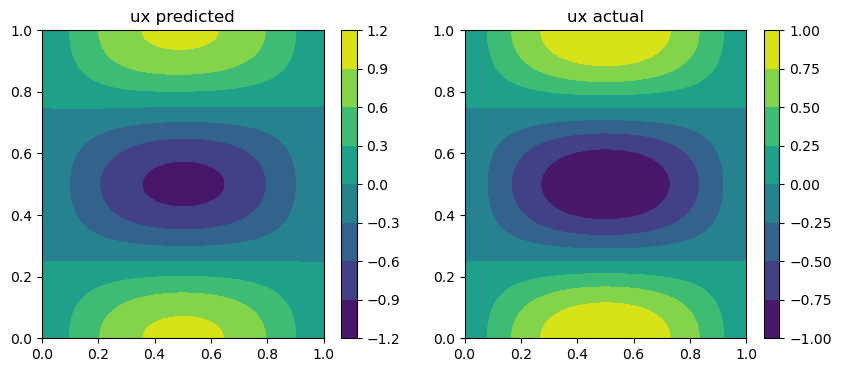

In [37]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the first contour plot on the first subplot
cf1 = axs[0].contourf(b.cpu().detach().numpy(), b.cpu().detach().numpy(), ux_pred.cpu().detach().numpy())
axs[0].set_title('ux predicted')

# Plot the second contour plot on the second subplot
cf2 = axs[1].contourf(b.cpu().detach().numpy(), b.cpu().detach().numpy(), ux_actual.cpu().detach().numpy())
axs[1].set_title('ux actual')

# Add a color bar to each subplot
fig.colorbar(cf1, ax=axs[0])
fig.colorbar(cf2, ax=axs[1])

# Show the plot
plt.show()

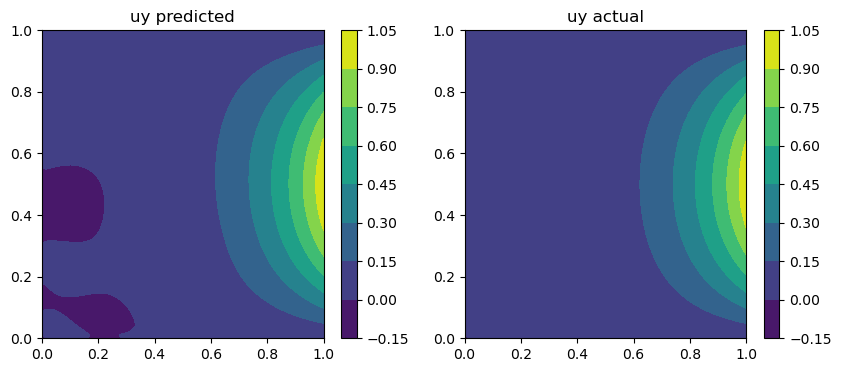

In [38]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the first contour plot on the first subplot
cf1 = axs[0].contourf(b.cpu().detach().numpy(), b.cpu().detach().numpy(), uy_pred.cpu().detach().numpy())
axs[0].set_title('uy predicted')

# Plot the second contour plot on the second subplot
cf2 = axs[1].contourf(b.cpu().detach().numpy(), b.cpu().detach().numpy(), uy_actual.cpu().detach().numpy())
axs[1].set_title('uy actual')

# Add a color bar to each subplot
fig.colorbar(cf1, ax=axs[0])
fig.colorbar(cf2, ax=axs[1])

# Show the plot
plt.show()

# plotting

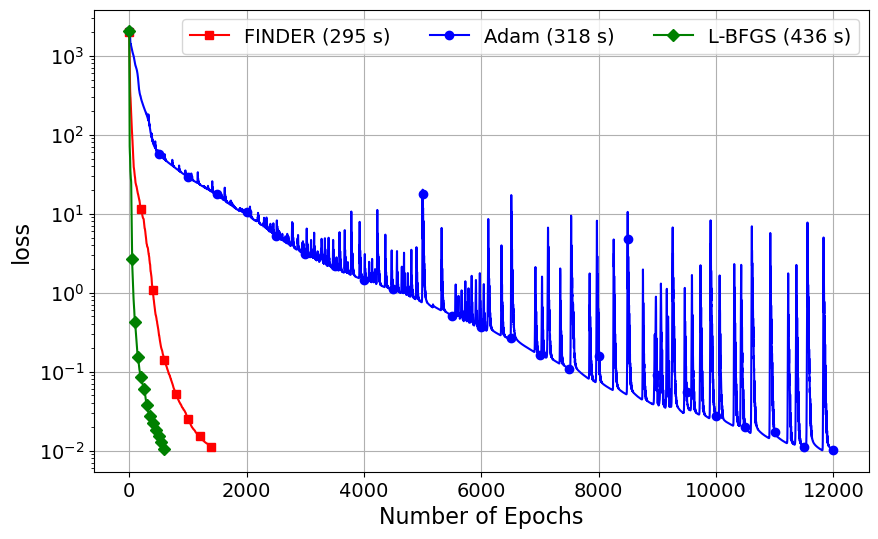

In [39]:
# Set figure size
fig = plt.gcf()
fig.set_size_inches(10, 6)  # width, height
ax = plt.axes()


plt.plot(fx, 'rs-', markevery= 200, label=f"FINDER ({runtime_FINDER} s)")
plt.plot(fx_adam, 'bo-', markevery= 500, label=f"Adam ({runtime_adam} s)")
plt.plot(fx_LBFGS, 'gD-', markevery= 50, label=f"L-BFGS ({runtime_lbfgs} s)")

plt.ylabel('loss', fontsize=16)
plt.xlabel('Number of Epochs', fontsize=16)
plt.legend(loc="best", ncol=3, fontsize=14)
plt.yscale('log')
plt.grid()
plt.tick_params(axis='both', labelsize=14)
plt.show()

# save data

In [40]:
torch.save(torch.tensor(fx), f'../PlotData/elasticity/elasticity_FINDER_N{pinn.start.shape[0]}_{runtime_FINDER}s.pt')

In [41]:
torch.save(torch.tensor(fx_adam), f'../PlotData/elasticity/elasticity_Adam_N{pinn.start.shape[0]}_{runtime_adam}s.pt')

In [42]:
torch.save(torch.tensor(fx_LBFGS), f'../PlotData/elasticity/elasticity_lbfgs_N{pinn.start.shape[0]}_{runtime_lbfgs}s.pt')